## Import thư viện

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import warnings
import os
import cv2

In [2]:
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

## Đọc dữ liệu

### Dữ liệu huấn luyện

In [3]:
path = "../../data/train/Fish_Dataset"  # đường dẫn đến thư mục chứa dữ liệu
classes = [i for i in os.listdir(path) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [4]:
data = [] # mảng chứa dữ liệu
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data.append([img, folder])

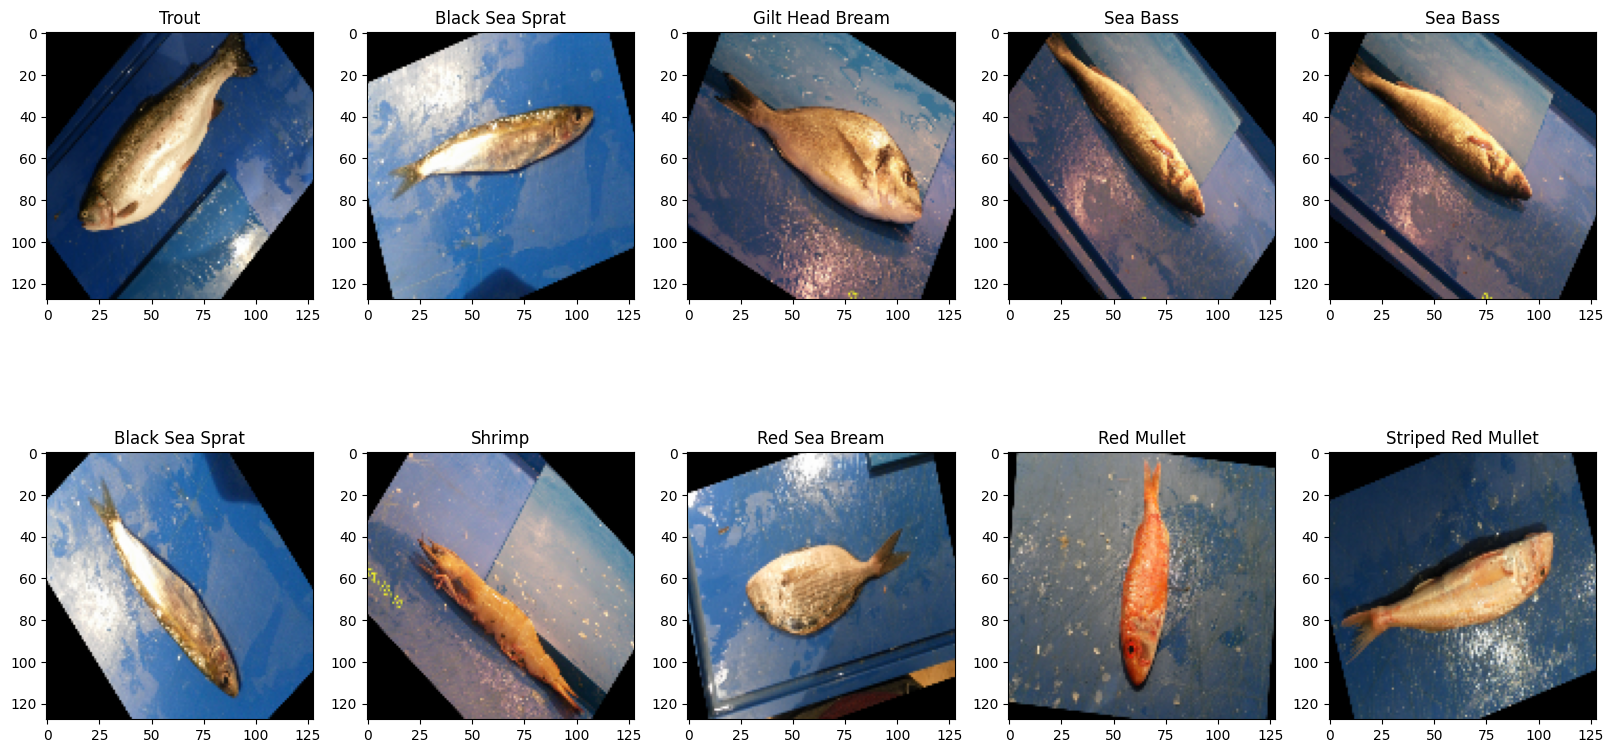

In [5]:
# hiện thị một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 9000)
    plt.imshow(data[j+i][0])
    plt.title(data[j+i][1])

In [6]:
# tạo image và label từ data
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)

In [7]:
# chuấn hóa label thành dạng số
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [8]:
# chuyển images thành numpy array và chuẩn hóa về khoảng [0, 1]
images = np.array(images)
images = images.astype('float32') / 255.0
images.shape

(9000, 128, 128, 3)

In [9]:
# duỗi ảnh thành vector
images = images.reshape(images.shape[0], -1) # 9000 ảnh, mỗi ảnh có 128x128x3 = 49,152 pixel

In [10]:
# dùng PCA để giảm chiều dữ liệu xuống còn 95% thông tin
pca = PCA(0.95)
images = pca.fit_transform(images)

#### Chia dữ liệu Train và Validation

In [11]:
# chia train, validation sao cho các lớp có số lượng ảnh tương đương nhau
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)

train_images.shape, val_images.shape, train_labels.shape, val_labels.shape

((7200, 1087), (1800, 1087), (7200,), (1800,))

In [12]:
# đếm số lượng ảnh của mỗi lớp trong tập train
unique, counts = np.unique(train_labels, return_counts=True)
dict(zip(unique, counts))

{0: 800, 1: 800, 2: 800, 3: 800, 4: 800, 5: 800, 6: 800, 7: 800, 8: 800}

### Dữ liệu kiểm tra (Test)

In [13]:
data_test = []
path = "../../data/test/NA_Fish_Dataset"
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    num_images = len(os.listdir(folder_path))  # Đếm số lượng ảnh trong thư mục
    for i in range(1, num_images + 1):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data_test.append([img, folder])

In [14]:
# shuffle data_test
import random
random.shuffle(data_test)

In [15]:
# tạo image và label từ data_test
test_images = []
test_labels = []
for image, label in data_test:
    test_images.append(image)
    test_labels.append(label)

In [16]:
# chuấn hóa label
le = LabelEncoder()
test_labels = le.fit_transform(test_labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [17]:
# chuyển images thành numpy array và chuẩn hóa về khoảng [0, 1]
test_images = np.array(test_images)
test_images = test_images.astype('float32') / 255.0
test_images.shape

(430, 128, 128, 3)

In [18]:
# duỗi ảnh thành vector
test_images = test_images.reshape(test_images.shape[0], -1) # 9000 ảnh, mỗi ảnh có 128x128x3 = 49,152 pixel

In [19]:
test_images = pca.transform(test_images)

## Xây dựng model

In [20]:
# chuyển label thành dạng one-hot-coding
def convert_labels(y, C): # C là số lượng nhãn, hàm này chuyển vector nhãn y sang dạng ma trận one-hot-coding
    Y = sparse.coo_matrix((np.ones_like(y),
                           (y, np.arange(len(y)))), shape=(C, len(y))).toarray()
    return Y

In [21]:
def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z), axis = 0)
    return A

In [22]:
def softmax_regression(X, y, W_init, eta, tol = 1e-6, max_count = 100000): # hàm này dùng để train softmax regression
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, C) # Y là ma trận one-hot coding của y
    it = 0
    N = X.shape[1]
    d = X.shape[0]

    count = 0
    check_w_after = 10000
    while count < max_count:
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)

            ai = softmax(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta * xi.dot((yi - ai).T)
            count += 1

            if count % check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

In [23]:
def cost(X, Y, W):
    A = softmax(W.T.dot(X))
    return -np.sum(Y*np.log(A))

def predict(W, X):
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis = 0)

In [24]:
X_train = train_images.T
X_val = val_images.T

In [25]:
eta = 0.05
d = X_train.shape[0] # số chiều của dữ liệu
W_init = np.random.randn(X_train.shape[0], 9) # khởi tạo W có kích thước là (d, C) d là số chiều của dữ liệu, C là số lượng nhãn
# print(W_init.shape)
W = softmax_regression(X_train, train_labels, W_init, eta)
# print(W[-1])

### Dữ liệu train

In [26]:
y_pred = predict(W[-1], X_train)

In [27]:
# hiển thị các chỉ số đánh giá mô hình
print(classification_report(train_labels, y_pred, target_names=le.classes_))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.97      0.99      0.98       800
   Gilt Head Bream       0.94      0.99      0.96       800
   Hourse Mackerel       0.98      0.99      0.98       800
        Red Mullet       1.00      0.99      1.00       800
     Red Sea Bream       0.99      0.99      0.99       800
          Sea Bass       0.99      0.98      0.98       800
            Shrimp       0.99      0.99      0.99       800
Striped Red Mullet       0.97      0.95      0.96       800
             Trout       0.96      0.92      0.94       800

          accuracy                           0.98      7200
         macro avg       0.98      0.98      0.98      7200
      weighted avg       0.98      0.98      0.98      7200



### Dữ liệu validation

In [28]:
# dự đoán nhãn của tập validation
y_pred = predict(W[-1], X_val)

Text(0.5, 23.52222222222222, 'Predicted label')

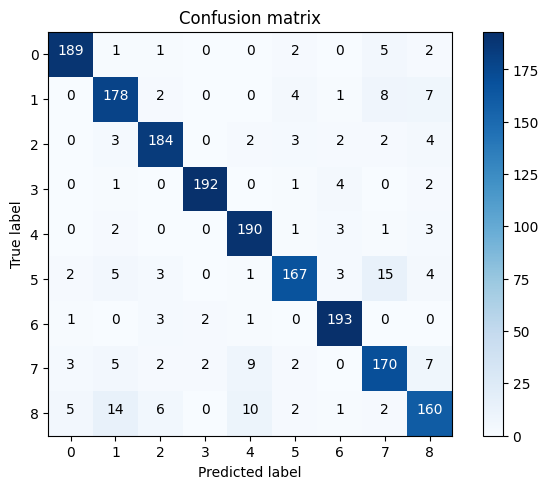

In [29]:
classes = 9

cm = confusion_matrix(val_labels, y_pred)

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [30]:
# hiển thị các chỉ số đánh giá mô hình
print(classification_report(val_labels, y_pred, target_names=le.classes_))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.94      0.94      0.94       200
   Gilt Head Bream       0.85      0.89      0.87       200
   Hourse Mackerel       0.92      0.92      0.92       200
        Red Mullet       0.98      0.96      0.97       200
     Red Sea Bream       0.89      0.95      0.92       200
          Sea Bass       0.92      0.83      0.87       200
            Shrimp       0.93      0.96      0.95       200
Striped Red Mullet       0.84      0.85      0.84       200
             Trout       0.85      0.80      0.82       200

          accuracy                           0.90      1800
         macro avg       0.90      0.90      0.90      1800
      weighted avg       0.90      0.90      0.90      1800



### Dữ liệu kiểm tra

In [31]:
# dự đoán kết quả
y_pred = predict(W[-1], test_images.T)

Text(0.5, 23.52222222222222, 'Predicted label')

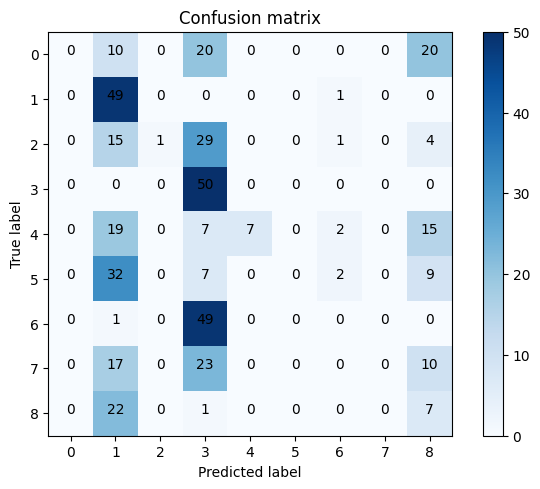

In [32]:
classes = 9

cm = confusion_matrix(test_labels, y_pred)

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [33]:
warnings.filterwarnings('ignore')
# hiển thị các chỉ số đánh giá mô hình
print(classification_report(test_labels, y_pred, target_names=le.classes_))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.00      0.00      0.00        50
   Gilt Head Bream       0.30      0.98      0.46        50
   Hourse Mackerel       1.00      0.02      0.04        50
        Red Mullet       0.27      1.00      0.42        50
     Red Sea Bream       1.00      0.14      0.25        50
          Sea Bass       0.00      0.00      0.00        50
            Shrimp       0.00      0.00      0.00        50
Striped Red Mullet       0.00      0.00      0.00        50
             Trout       0.11      0.23      0.15        30

          accuracy                           0.27       430
         macro avg       0.30      0.26      0.15       430
      weighted avg       0.31      0.27      0.15       430



In [34]:
print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=test_labels))
print("Precision: ", precision_score(y_pred=y_pred, y_true=test_labels, average='weighted'))
print("Recall: ", recall_score(y_pred=y_pred, y_true=test_labels, average='weighted'))

Accuracy:  0.2651162790697674
Precision:  0.30586073091699495
Recall:  0.2651162790697674
